# Classifying Song Genres from Audio Data
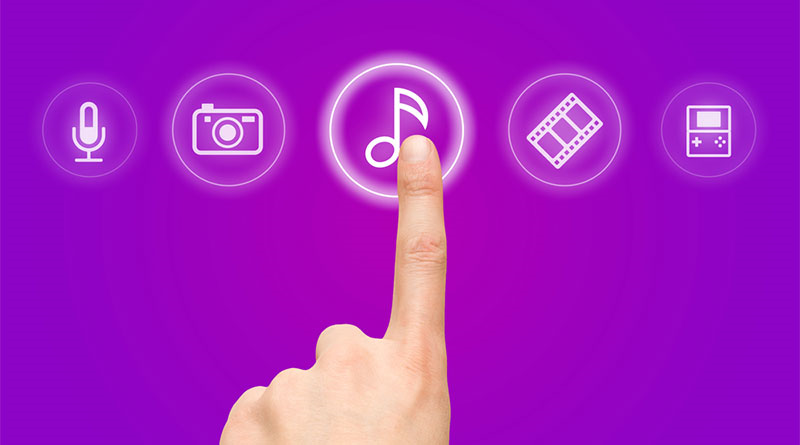

Over the past few years, streaming services have become the primary means through which most people listen to their favorite music. However, this can mean that users might find it difficult to look for newer music that suits their tastes.

Hence, streaming services aim at categorizing music to allow for personalized recommendations. 
This analysis in this article will look through datasets to classify songs as being either 'Hip-Hop' or 'Rock' without listening to a single one ourselves. The process of problem-solving will follow the steps of data cleaning, EDA and use feature reduction followed by building a machine learning based logistic regression model.

Let us begin by loading information about our tracks alongside the track metrics compiled by The Echo Nest. Further, we also have data about the musical features of each track such as danceability and acousticness.

In [1]:
#Importing the pandas library
import pandas as pd

In [2]:
# Reading the track metadata with genre labels
tracks = pd.read_csv('fma-rock-vs-hiphop.csv')

# Read in track metrics with the features
echonest_metrics = pd.read_json('echonest-metrics.json')

In [3]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17734 entries, 0 to 17733
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   track_id       17734 non-null  int64 
 1   bit_rate       17734 non-null  int64 
 2   comments       17734 non-null  int64 
 3   composer       166 non-null    object
 4   date_created   17734 non-null  object
 5   date_recorded  1898 non-null   object
 6   duration       17734 non-null  int64 
 7   favorites      17734 non-null  int64 
 8   genre_top      17734 non-null  object
 9   genres         17734 non-null  object
 10  genres_all     17734 non-null  object
 11  information    482 non-null    object
 12  interest       17734 non-null  int64 
 13  language_code  4089 non-null   object
 14  license        17714 non-null  object
 15  listens        17734 non-null  int64 
 16  lyricist       53 non-null     object
 17  number         17734 non-null  int64 
 18  publisher      52 non-null

In [4]:
echonest_metrics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13129 entries, 0 to 13128
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          13129 non-null  int64  
 1   acousticness      13129 non-null  float64
 2   danceability      13129 non-null  float64
 3   energy            13129 non-null  float64
 4   instrumentalness  13129 non-null  float64
 5   liveness          13129 non-null  float64
 6   speechiness       13129 non-null  float64
 7   tempo             13129 non-null  float64
 8   valence           13129 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 1.0 MB


In [5]:
# Merging relevant columns of tracks and echonest_metrics
echo_tracks = echonest_metrics.merge(tracks[['genre_top', 'track_id']], on='track_id')

# Inspecting the resultant dataframe
echo_tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
 9   genre_top         4802 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB


# Pairwise relationships between continuous variables

The process suggests avoiding using variables that have strong correlations with each other as they might lead to feature redundancy. Hence it is best to:

- Keep the model simple to reduce overfitting and improve interpretability and
- Use fewer features to make the process computationally effective.


In [6]:
# Building the correlation matrix
corr_metrics = echonest_metrics.corr()
corr_metrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.279829,0.102056,0.121991,-0.283206,-0.004059,-0.075077,0.004313,0.020201
acousticness,-0.279829,1.000000,-0.189599,-0.477273,0.110033,0.041319,0.038785,-0.110701,-0.085436
danceability,0.102056,-0.189599,1.000000,0.045345,-0.118033,-0.143339,0.171311,-0.094352,0.428515
energy,0.121991,-0.477273,0.045345,1.000000,-0.002412,0.045752,-0.008645,0.227324,0.219384
instrumentalness,-0.283206,0.110033,-0.118033,-0.002412,1.000000,-0.058593,-0.216689,0.023003,-0.145200
liveness,-0.004059,0.041319,-0.143339,0.045752,-0.058593,1.000000,0.073104,-0.007566,-0.017886
speechiness,-0.075077,0.038785,0.171311,-0.008645,-0.216689,0.073104,1.000000,0.032188,0.094794
tempo,0.004313,-0.110701,-0.094352,0.227324,0.023003,-0.007566,0.032188,1.000000,0.129911
valence,0.020201,-0.085436,0.428515,0.219384,-0.145200,-0.017886,0.094794,0.129911,1.000000


# Normalizing the feature data

The output above does not show any significantly strong correlations. Hence we can proceed to reducing the number of features using 'Principal Component Analysis' (PCA).

The variance between genres can be explained by a few features. PCA rotates the data along the axis of highest variance, thus allowing us to determine the relative contribution of each feature of our data towards the variance between classes.

However, PCA uses the absolute variance of a feature to rotate the data. This means that a feature with a broader range of values will overpower and bias the algorithm relative to the other features. To handle this, let us first normalize the data through standardization to generate all features with mean = 0 and standard deviation = 1 as seen below.

In [7]:
# Defining the features
features = echo_tracks.drop(columns=['genre_top', 'track_id']) 

# Defining labels
labels = echo_tracks['genre_top']

In [8]:
# Importing the StandardScaler
from sklearn.preprocessing import StandardScaler

# Scaling the features and setting the values to a new variable
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(features)

# Principal Component Analysis on scaled data

We are now ready to use PCA to determine by how much we can reduce the dimensionality of the data. Further, to find the number of components to use ahead, we can construct scree-plots and cumulative explained ratio plots.
Scree-plots display the number of components against the variance explained by each component, sorted in descending order of variance. The'elbow' that is a steep drop from one data point to the next, seen in the plot, decides an appropriate cutoff.

Text(0.5, 0, 'Principal Component #')

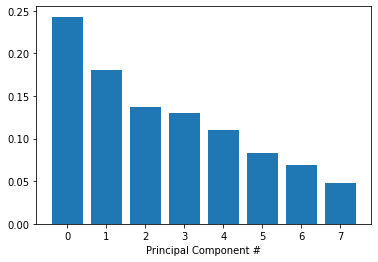

In [9]:
%matplotlib inline 

# Importing the plotting module and PCA 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Getting explained variance ratios from PCA using all features
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_

# Plotting the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), exp_variance)
ax.set_xlabel('Principal Component #')

#  Further visualization of PCA

The scree-plot above does not come up with a clear elbow so instead, let us look at the cumulative explained variance plot to determine how many features are required to explain, approximately 85% of the variance.

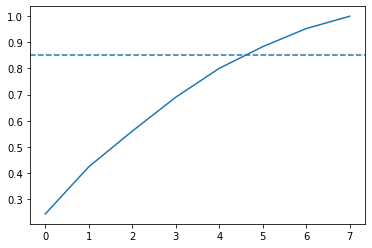

In [10]:
# Import numpy
import numpy as np

# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)

# Plot the cumulative explained variance and draw a dashed line at 0.85.
fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.85, linestyle='--')

# choose the n_components where about 85% of our variance can be explained
n_components = 6

# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components, random_state=10)
pca.fit(scaled_train_features)
pca_projection =  pca.transform(scaled_train_features)

# Logistic Regression Model

Now we can use the lower dimensional PCA projection of the data to classify songs into genres. Let us build a logistic regression model by first splitting our dataset into 'train' and 'test' subsets, where the 'train' is used to train our model while the 'test' dataset allows for model performance validation. Further, Logistic Regression uses the logistic function to calculate the odds that a given data point belongs to a particular class. 

In [12]:
# Import train_test_split function and Decision tree classifier
from sklearn.model_selection import train_test_split

# Split our data
train_features, test_features, train_labels, test_labels =  train_test_split(pca_projection, labels, random_state=10)

In [13]:
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

# Training our logisitic regression
logreg = LogisticRegression(random_state=10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

# Creating the classification report for the model
from sklearn.metrics import classification_report
class_rep_log = classification_report(test_labels, pred_labels_logit)

print("Logistic Regression: \n", class_rep_log)

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.77      0.54      0.64       235
        Rock       0.90      0.96      0.93       966

    accuracy                           0.88      1201
   macro avg       0.83      0.75      0.78      1201
weighted avg       0.87      0.88      0.87      1201



# Balancing the data for better performance

The classification report shows us that rock songs are fairly well classified, but hip-hop songs are disproportionately misclassified as rock songs.  There are far more data points for the rock classification than for hip-hop which skew our model's ability to distinguish between classes. This also means that most of our logistic model's accuracy is driven by its ability to classify just rock songs and these are hence not very good results.

To account for this, we can weight the value of a correct classification in each class inversely to the occurrence of data points for each class.

In [14]:
# Subset a balanced proportion of data points
hop_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Hip-Hop']
rock_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Rock']

# subset only the rock songs, and take a sample the same size as there are hip-hop songs
rock_only = rock_only.sample(hop_only.shape[0], random_state=10)

# Concatenate the dataframes hop_only and rock_only
rock_hop_bal = pd.concat([rock_only, hop_only])

# The features, labels, and pca projection are created for the balanced dataframe
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']
pca_projection = pca.fit_transform(scaler.fit_transform(features))

# Redefine the train and test set with the pca_projection from the balanced data
train_features, test_features, train_labels, test_labels = train_test_split(
    pca_projection, labels, random_state=10)

In [15]:
rock_hop_bal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1820 entries, 773 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          1820 non-null   int64  
 1   acousticness      1820 non-null   float64
 2   danceability      1820 non-null   float64
 3   energy            1820 non-null   float64
 4   instrumentalness  1820 non-null   float64
 5   liveness          1820 non-null   float64
 6   speechiness       1820 non-null   float64
 7   tempo             1820 non-null   float64
 8   valence           1820 non-null   float64
 9   genre_top         1820 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 156.4+ KB


# Balancing improves model bias?

The dataset is now balanced, but it has removed a lot of data points. Let us now test to see if balancing our data improves model bias towards the "Rock" classification while retaining overall classification performance.

In [16]:
# Training our logistic regression on the balanced data
logreg = LogisticRegression(random_state=10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)
print("Logistic Regression: \n", classification_report(test_labels, pred_labels_logit))

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.84      0.80      0.82       230
        Rock       0.80      0.85      0.83       225

    accuracy                           0.82       455
   macro avg       0.82      0.82      0.82       455
weighted avg       0.82      0.82      0.82       455



#  Cross-validation for evaluation

Balancing our data has removed bias but to get a good sense of actual performance, we can apply called cross-validation (CV). 
CV attempts to split the data multiple ways and test the model on each of the splits. Hereby, K-fold CV first splits the data into K different, equally sized subsets and iteratively uses each subset as a test set while using the remainder of the data as train sets. Finally, it aggregates the results from each fold and gives out a final model performance score.

In [17]:
from sklearn.model_selection import KFold, cross_val_score

# Setting up K-fold cross-validation
kf = KFold(10)

logreg = LogisticRegression(random_state=10)

# Training our model using KFold cv
logit_score = cross_val_score(logreg, pca_projection, labels, cv=kf)

# Print the mean of each array o scores
print("Logistic Regression:", np.mean(logit_score))

Logistic Regression: 0.782967032967033
